# General setup

In [1]:
# General setup
import numpy as np
import os
import os.path as op
import matplotlib.pyplot as plt
from langouEEG import *
from scipy.stats import *
from eeg_microstates3 import *
import pandas as pd
import time
import mne
import pickle
from mne.datasets import sample
from mne.datasets import fetch_fsaverage
from mpl_toolkits.mplot3d import Axes3D  # noqa
from langouMicrostates import *
from IPython.display import clear_output as clear
import logging
# import easyEEG

sample_data_folder = mne.datasets.sample.data_path()
# dataRoot = "/data/home/viscent/Light"
dataRoot = "/work/zhangyq/Light/"


# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = False
isAll = True
isBlind = False
if not isAll:
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
else:
    result_dir = op.join(dataRoot,'result','all')
subjects_dir = op.dirname(fs_dir)
if not op.exists(result_dir):
    os.mkdir(result_dir)
# The files live in:


0 files missing from root.txt in /work/zhangyq/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /work/zhangyq/mne_data/MNE-fsaverage-data/fsaverage


# Read the data

In [2]:
%%capture
## Input EEG data and extarct epochs

epochs_4F = dict()
epochs_RF = dict()
epochs_4R = dict()
epochs_RR = dict()
#epochs_all = dict()


# tmin_rest, tmax_rest, tmin_flick,tmax_flick = 40, 60, 15, 30
# tmin_rest, tmax_rest, tmin_flick,tmax_flick = 40, 50, 15, 22
tmin_rest, tmax_rest, tmin_flick,tmax_flick = 5, 25, 5, 25
# tmin_R_flick, tmax_R_flick = 20, 25
# tmin_R_flick, tmax_R_flick = 20, 22
tmin_R_flick, tmax_R_flick = 5, 25

# Total 1-21
# 1-11 and 12-21
epoch_num = 0
for subject_name in range(1,21):
    if not isAll:
        if not (isMale ^ (subject_name in [7,8,11,17])):
            continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data_av/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')

    epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs_forall(raw,events,picks, 
    tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_flick,tmax_flick = tmax_flick)
    # 为啥搞两遍？
    ## A: 因为之前random与40Hz取的时间段不同，我写的垃圾代码只能传进一个tmin_flick
    ### Q: 我看也没区别啊
    #### A: 因为现在tmin,tmax是一样的，以前是不一样的
    _,epoch_RF,_,_ = extractEpochs_forall(raw,events,picks, 
    tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_R_flick,tmax_flick = tmax_R_flick)
    epochs_4F[subject_name]=epoch_4F
    epochs_RF[subject_name]=epoch_RF
    epochs_RR[subject_name]=epoch_RR
    epochs_4R[subject_name]=epoch_4R
    #epochs_all[epoch_num] = epoch_4R
    #epochs_all[epoch_num+1] = epoch_4F
    #epochs_all[epoch_num+2] = epoch_RF
 
    data_path = sample.data_path()

    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')

    epoch_num += 3
    # Clear output display
    clear()

## Concact epochs
epoch_4F = mne.concatenate_epochs(list(epochs_4F.values()))
epoch_RF = mne.concatenate_epochs(list(epochs_RF.values()))
epoch_4R = mne.concatenate_epochs(list(epochs_4R.values()))
# epoch_all = mne.concatenate_epochs(list(epochs_all.values()))
# mne.epochs.equalize_epoch_counts([epoch_4F, epoch_RF, epoch_RR])

# Clear output display
clear()

# Concatenate all epochs in all conditions

In [3]:
epoch_all = mne.concatenate_epochs([epoch_4F, epoch_RF, epoch_4R])
epoch_dur = np.zeros((3))
epoch_dur = [epoch_4F.get_data().shape[0]*epoch_4F.get_data().shape[2],epoch_RF.get_data().shape[0]*epoch_RF.get_data().shape[2],epoch_4R.get_data().shape[0]*epoch_4R.get_data().shape[2]]
epoch_count = [epoch_4F.get_data().shape[0],epoch_RF.get_data().shape[0],epoch_4R.get_data().shape[0]]
epoch_size = epoch_all.get_data().shape[2]

Not setting metadata
Not setting metadata
302 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


# Do MS analysis

(3020302, 64)


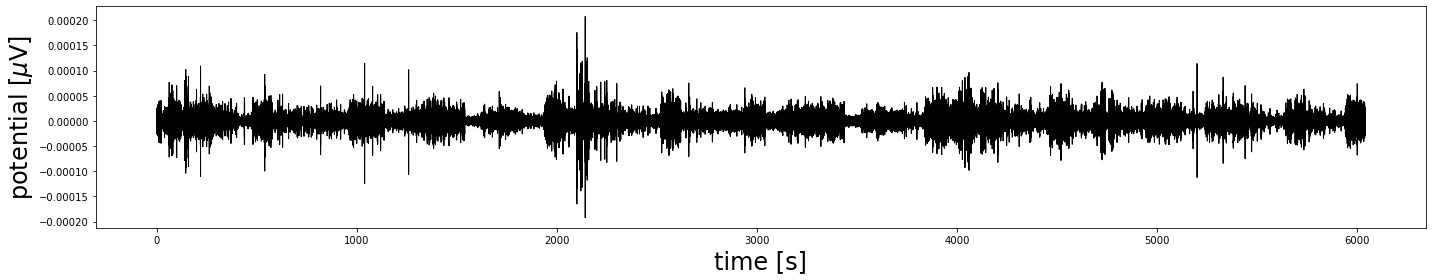

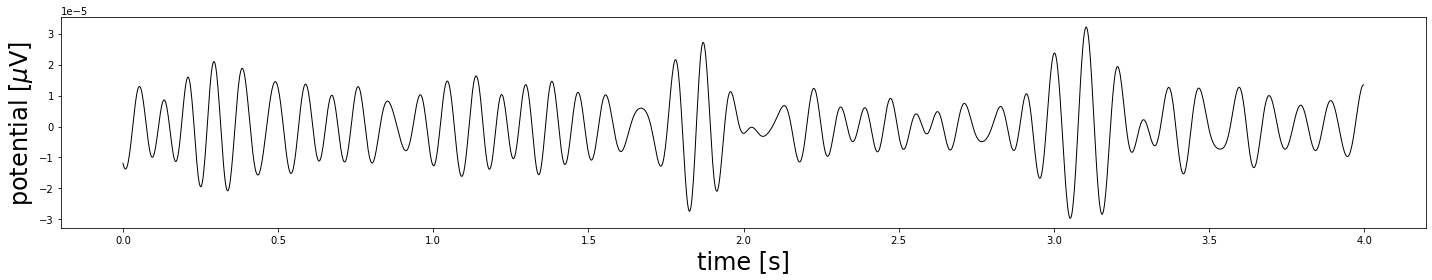

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 126860 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 53 iterations.
	K-means run 2/5 converged after 49 iterations.
	K-means run 3/5 converged after 116 iterations.
	K-means run 4/5 converged after 49 iterations.
	K-means run 5/5 converged after 52 iterations.
[+] Computation time: 62.97 sec

[+] Microstate back-fitting:
data_norm:  (3020302, 64)
data_cluster_norm:  (126860, 64)
maps:  (8, 64)

[+] Global explained variance GEV = 0.632
GEV_0: 0.076
GEV_1: 0.031
GEV_2: 0.108
GEV_3: 0.072
GEV_4: 0.093
GEV_5: 0.064
GEV_6: 0.095
GEV_7: 0.095

Empirical symbol distribution (RTT):

p_0 = 0.237
p_1 = 0.003
p_2 = 0.225
p_3 = 0.228
p_4 = 0.009
p_5 = 0.004
p_6 = 0.177
p_7 = 0.117

Empirical transition matrix:

|0.8690.0010.0320.0560.0020.0010.0260.015|
|0.0490.7020.0580.0460.0340.0070.0500.052|
|0.0340.0010.8870.0320.0020.0010.0280.015|
|0.0570.0010.0320.8640.0020.0010.0300.015|
|0

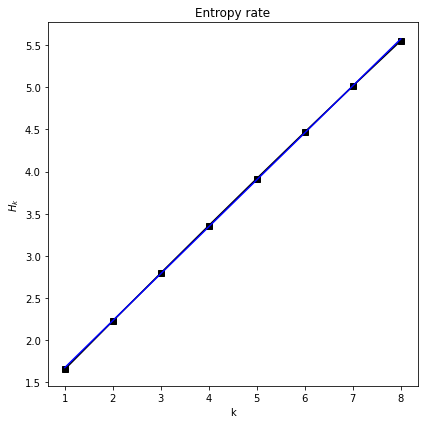


Empirical entropy rate h = 0.56
Theoretical MC entropy rate h = 0.57


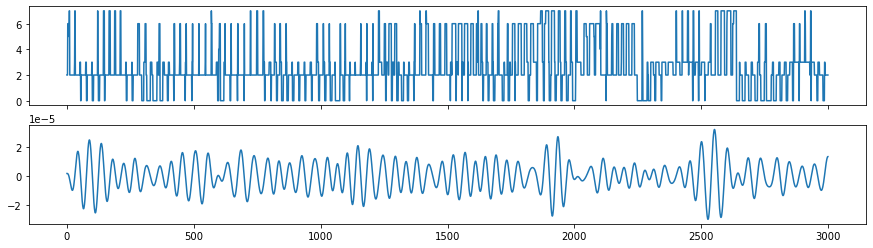

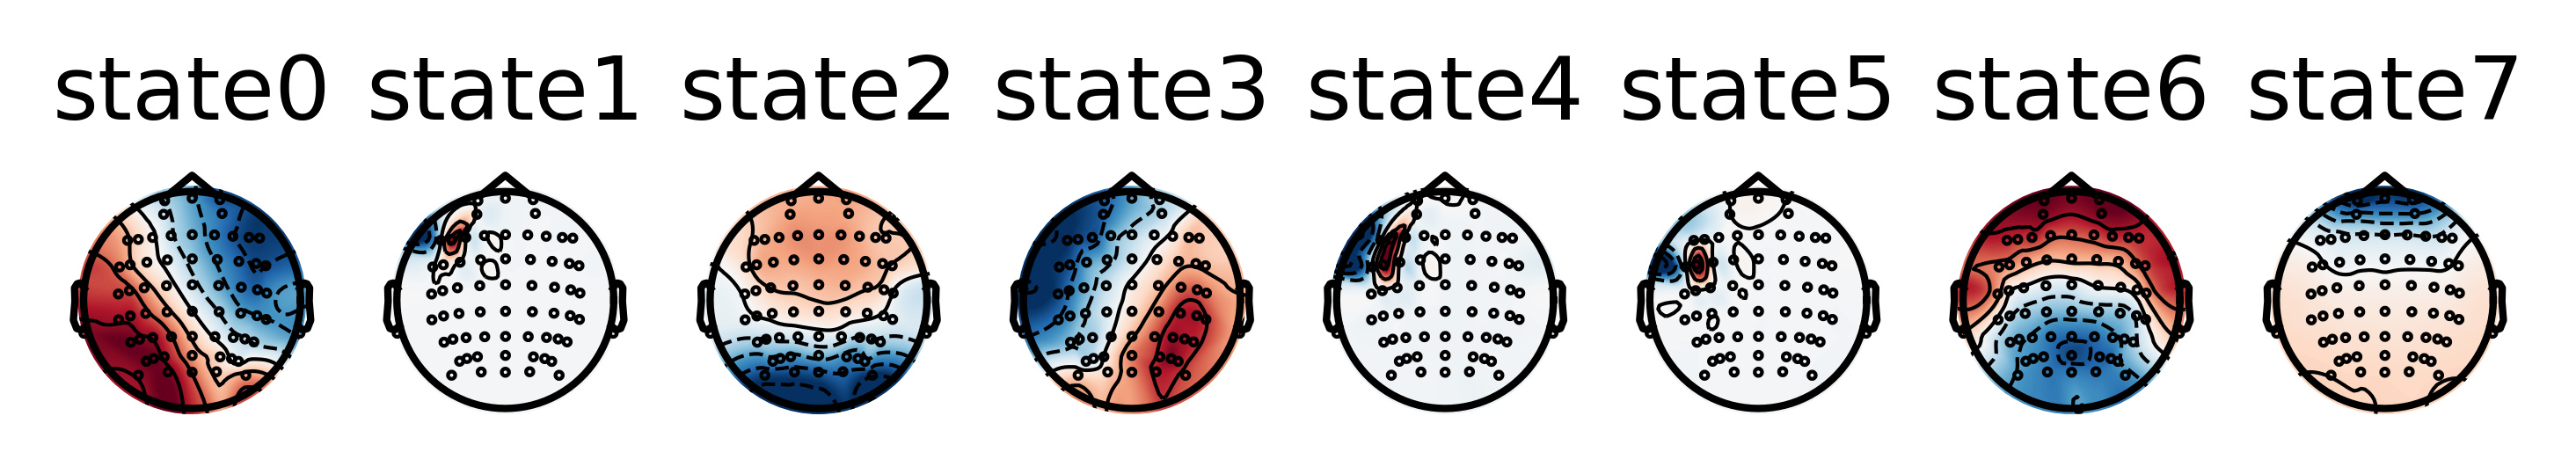

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

In [4]:
# epochs_order = list(epochs_4R.values())
# for i in list(epochs_4F.values()):
#     epochs_order.append(i)
# for i in list(epochs_RF.values()):
#     epochs_order.append(i)
# epoch_order = mne.concatenate_epochs(epochs_order)
epoch_order = epoch_all

dataRoot = "/work/zhangyq/Light/"

result_dir = dataRoot + "result/microstates"
tm = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
time_augs=[['min_rest','max_rest','min_flick','max_flick','min_random_flick','max_random_flick']
,[tmin_rest, tmax_rest, tmin_flick, tmax_flick, tmin_R_flick, tmax_R_flick]]

# Args to save MS result
save = True
to_save_cache = True
save_log = True

from langouEEG import *
# mode: "aahc", "kmeans", "kmedoids", "pca", "ica"
vars_all = display_maps(epoch_order, n_maps=8, save=save, dpi=600, filename='all',
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=False, epochs=epoch_order,save_log=save_log, f_lo=8, f_hi=13, mode=1)

# Wash the data, seperate the data according to different conditions

In [5]:
maps = vars_all[0]

In [6]:
ABCD_ = input("Please input the ABCD sequence, e.g.: 0,1,2,3").split(',')
ABCD = [int(ABCD_[i]) for i in range(len(ABCD_))]
# ABCD = [3,1,2,6]
state_A = maps[ABCD[0]]
state_B = maps[ABCD[1]]
state_C = maps[ABCD[2]]
state_D = maps[ABCD[3]]

In [7]:
np.save(result_dir+'/state_A.npy',state_A)
np.save(result_dir+'/state_B.npy',state_B)
np.save(result_dir+'/state_C.npy',state_C)
np.save(result_dir+'/state_D.npy',state_D)

In [8]:
import math
def GMD(u,v):
    u_bar = np.mean(u,axis=0)
    v_bar = np.mean(v,axis=0)
    n = u.shape[0]
    sigma_diff = 0
    for i in range(n):
        a = 0
        b = 0
        for j in range(n):
            a += ((u[j]-u_bar)**2)/n
            b += ((v[j]-v_bar)**2)/n
        a = math.sqrt(a)
        b = math.sqrt(b)
        a = (u[i]-u_bar)/a
        b = (v[i]-v_bar)/b
        sigma_diff += (a-b)**2
    return math.sqrt(sigma_diff/n)
GMD_mat = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        GMD_mat[i,j] = GMD(maps[i],maps[j])
def pGMD(u,v):
    return GMD_mat[u,v]

In [9]:
maps = vars_all[0]
temp = np.zeros((maps.shape[0]))
state_A = np.load(result_dir+'/state_A.npy')
for i in range(maps.shape[0]):
    temp[i] = abs(GMD(maps[i],state_A)-1)
idx_A = temp.argmax()

temp = np.zeros((maps.shape[0]))
state_B = np.load(result_dir+'/state_B.npy')
for i in range(maps.shape[0]):
    temp[i] = abs(GMD(maps[i],state_B)-1)
idx_B = temp.argmax()

temp = np.zeros((maps.shape[0]))
state_C = np.load(result_dir+'/state_C.npy')
for i in range(maps.shape[0]):
    temp[i] = abs(GMD(maps[i],state_C)-1)
idx_C = temp.argmax()

temp = np.zeros((maps.shape[0]))
state_D = np.load(result_dir+'/state_D.npy')
for i in range(maps.shape[0]):
    temp[i] = abs(GMD(maps[i],state_D)-1)
idx_D = temp.argmax()
map_idx = np.array([idx_A,idx_B,idx_C,idx_D])
map_canonical = np.array([state_A,state_B,state_C,state_D])


In [10]:
def reject_short(x):
    u = 0
    v = 1
    x_prev = x[0]
    rej_count = 0
    rej_tot = 0
    dur = []
    while True:
        while v<=x.shape[0]:
            if v > x.shape[0]-1:
                break
            if x[v]!=x_prev:
                if v-u < 15:
                    for i in range(u,v):
                        x[i] = 8
                dur.append(v-u)
                x_prev = x[v]
                u = v
                v += 1
            else:
                v += 1
        u = 0
        v = 1
        rej_count=np.sum(np.where(x==8,1,0))
        print(rej_count)
        rej_tot+=rej_count
        while v<=x.shape[0]:
            if v > x.shape[0]-1:
                break
            if x[v] == 8:
                u = v
                while v < x.shape[0]:
                    if x[v]!=8:
                        break
                    else:
                        v+=1
                mid = math.floor(u+(v-u)/2)
                if mid>x.shape[0] or v > x.shape[0]-1:
                    break
                for i in range(u,mid):
                    x[i] = x[u-1]
                for i in range(mid,v):
                    x[i] = x[v]
                u=v-1
            else:
                v += 1
        if rej_count < 3:
            x[np.where(x==8)]=map_idx[0]
            break
    return x,rej_tot

In [11]:
# return maps, x, gfp_peaks, gev, data, pca1
x = vars_all[1].copy()
gfp = vars_all[2].copy()
gfp_l = np.zeros(x.shape[0])
gfp_l[gfp] = 1
x_4F = vars_all[1][0:epoch_dur[0]]
x_RF = vars_all[1][epoch_dur[0]:epoch_dur[0]+epoch_dur[1]]
x_4R = vars_all[1][epoch_dur[0]+epoch_dur[1]:epoch_dur[0]+epoch_dur[1]+epoch_dur[2]]

In [12]:

def backfit(x):
    if np.isin(x,map_idx):
        for i in range(map_idx.shape[0]):
            if x == map_idx[i]:
                ret = i
    else:
        temp_GMD = np.zeros(map_idx.shape[0])
        for i in range(map_canonical.shape[0]):
            temp_GMD[i] = abs(pGMD(x,map_idx[i])-1)
        ret = temp_GMD.argmax()
    return ret
vbackfit = np.vectorize(backfit)

In [13]:

x_clean_4F = np.zeros((x_4F.shape[0]),dtype=np.int16)
gfp_4F = np.zeros(x_4F.shape[0],dtype=np.int16)
x_clean_4F = vbackfit(x_4F)
for j in range(x_4F.shape[0]):
    gfp_4F[j] = gfp_l[j]
        
x_clean_RF = np.zeros(x_RF.shape[0],dtype=np.int16)
gfp_RF = np.zeros(x_RF.shape[0],dtype=np.int16)
x_clean_RF = vbackfit(x_RF)
for j in range(x_RF.shape[0]):
    gfp_RF[j] = gfp_l[j]


x_clean_4R = np.zeros(x_4R.shape[0],dtype=np.int16)
gfp_4R = np.zeros(x_4R.shape[0],dtype=np.int16)
x_clean_4R = vbackfit(x_4R)
for j in range(x_4R.shape[0]):
    gfp_4R[j] = gfp_l[j]
    

In [14]:
x_clean_4F,rej_tot = reject_short(x_clean_4F)
reject_rate = rej_tot/x.shape[0]
# print(rej_tot)
print(str(reject_rate)+' data rejected for too short duration ( < 30ms)')
x_clean_RF,rej_tot = reject_short(x_clean_RF)
reject_rate = rej_tot/x.shape[0]
# print(rej_tot)
print(str(reject_rate)+' data rejected for too short duration ( < 30ms)')
x_clean_4R,rej_tot = reject_short(x_clean_4R)
reject_rate = rej_tot/x.shape[0]
# print(rej_tot)
print(str(reject_rate)+' data rejected for too short duration ( < 30ms)')

609945
6
3
2
0.20195199023144042 data rejected for too short duration ( < 30ms)
568462
5
3
2
0.18821693989541444 data rejected for too short duration ( < 30ms)
612698
2
0.20286050865112165 data rejected for too short duration ( < 30ms)


# Quantitative analysis
## Coverage

In [15]:
epoch_minimum = np.min(epoch_count)
coverage = np.zeros((3,epoch_minimum,4))
for i in range(epoch_minimum):
    coverage[0,i] = np.bincount(x_clean_4F[i*epoch_size:(i+1)*epoch_size],minlength=4)/epoch_size
    coverage[1,i] = np.bincount(x_clean_RF[i*epoch_size:(i+1)*epoch_size],minlength=4)/epoch_size
    coverage[2,i] = np.bincount(x_clean_4R[i*epoch_size:(i+1)*epoch_size],minlength=4)/epoch_size
print(coverage[0][0])
print(coverage[1][0])
print(coverage[2][0])

[0.10538946 0.25787421 0.17218278 0.46455354]
[0.29997    0.12128787 0.11558844 0.46315368]
[0.13778622 0.15348465 0.39966003 0.30906909]


### Save coverage

In [16]:
save_coverage_m=True

import pandas as pd
def save_var(save_folder, filename, data):
    # data is a *nd array*
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    writer = pd.ExcelWriter(save_folder + '/{0}'.format(filename))
    for i in range(data.shape[0]):
        data_write = pd.DataFrame(data[i])
        data_write.to_excel(writer, '{0}'.format(i), float_format='%.5f')
    writer.save()
    return

dataRoot = "/work/zhangyq/Light/"
result_dir = dataRoot + "result/microstates"
save_folder = result_dir + '/cache/' + tm

if save_coverage_m:
    save_var(save_folder=save_folder, filename="coverage_m.xlsx", data=coverage)

### Statistical analysis

In [17]:
'''pval matrix
4F-4R 0-7
RF-4R 8-15
4F-RF 16-23
'''
from statsmodels.stats.multitest import *
from scipy.stats import ttest_ind
pval = np.zeros(12)
for j in range(4):
    pval[j] = ttest_ind(coverage[0,:,j],coverage[2,:,j])[1]
    pval[4+j] = ttest_ind(coverage[1,:,j],coverage[2,:,j])[1]
    pval[8+j] = ttest_ind(coverage[0,:,j],coverage[1,:,j])[1]
fdr_val = fdrcorrection(pval,alpha=0.05,method='indep',is_sorted=False)
fdr_4F_4R = [fdr_val[0][0:4],fdr_val[1][0:4]]
fdr_RF_4R = [fdr_val[0][4:8],fdr_val[1][4:8]]
fdr_4F_RF = [fdr_val[0][8:12],fdr_val[1][8:12]]

fdr_val


(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.72469607, 0.72469607, 0.54921214, 0.72469607, 0.87651004,
        0.87651004, 0.36630226, 0.36630226, 0.72469607, 0.72469607,
        0.72469607, 0.50282906]))

## Frequency of occurance

In [18]:
def consecutive_count(x):
    u=0
    v=1
    prev = x[u]
    count = np.zeros(4)
    while v < x.shape[0]:
        if x[v]!=prev:
            count[prev]+=1
            prev = x[v]
            u=v
        v+=1
    count[prev] +=1 
    return count

In [19]:
freq_occur_4F = np.zeros((epoch_minimum,4))
for i in range(epoch_minimum):
    freq_occur_4F[i]=consecutive_count(x_clean_4F[i*epoch_size:(i+1)*epoch_size])/epoch_size*500

freq_occur_RF = np.zeros((epoch_minimum,4))
for i in range(epoch_minimum):
    freq_occur_RF[i]=consecutive_count(x_clean_RF[i*epoch_size:(i+1)*epoch_size])/epoch_size*500

freq_occur_4R = np.zeros((epoch_minimum,4))
for i in range(epoch_minimum):
    freq_occur_4R[i]=consecutive_count(x_clean_4R[i*epoch_size:(i+1)*epoch_size])/epoch_size*500

print(freq_occur_4R[0])
print(freq_occur_4F[0])
print(freq_occur_RF[0])

[0.79992001 0.99990001 1.19988001 1.14988501]
[0.54994501 0.69993001 0.54994501 0.94990501]
[1.04989501 0.64993501 0.49995    1.34986501]


In [20]:
freq_occur = np.array([freq_occur_4F,freq_occur_RF,freq_occur_4R])

### Save frequency of occurance

In [21]:
save_occur_m=True

dataRoot = "/work/zhangyq/Light/"
result_dir = dataRoot + "result/microstates"
save_folder = result_dir + '/cache/' + tm

if save_occur_m:
    save_var(save_folder=save_folder, filename="occurance_m.xlsx", data=freq_occur)

### Statistical analysis

In [22]:
##TODO: 做freq of occurrence的FDR，方法参考上下文
'''pval matrix
4F-4R
RF-4R
4F-RF
'''
from statsmodels.stats.multitest import *
from scipy.stats import ttest_ind
pval = np.zeros(12)
for j in range(4):
    pval[j] = ttest_ind(freq_occur_4F[:,j],freq_occur_4R[:,j])[1]
    pval[4+j] = ttest_ind(freq_occur_RF[:,j],freq_occur_4R[:,j])[1]
    pval[8+j] = ttest_ind(freq_occur_4F[:,j],freq_occur_RF[:,j])[1]
fdr_val_freq = fdrcorrection(pval,alpha=0.05,method='indep',is_sorted=False)
fdr_4F_4R_freq = [fdr_val_freq[0][0:4],fdr_val_freq[1][0:4]]
fdr_RF_4R_freq = [fdr_val_freq[0][4:8],fdr_val_freq[1][4:8]]
fdr_4F_RF_freq = [fdr_val_freq[0][8:12],fdr_val_freq[1][8:12]]

In [23]:
fdr_val_freq

(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.70597015, 0.89460151, 0.18418173, 0.9048366 , 0.70597015,
        0.70597015, 0.18418173, 0.18418173, 0.96057393, 0.70597015,
        0.82636423, 0.19647325]))

## Duration

In [24]:
dur_4F = np.zeros((epoch_minimum,4))
for i in range(epoch_minimum):
    u = v = 0
    prev_state = x_clean_4F[0]
    temp = [[],[],[],[]]
    for j in x_clean_4F[i*epoch_size:(i+1)*epoch_size]:
        if j != prev_state:
            temp[prev_state].append(v-u)
            u = v
            prev_state = j
        v += 1
    for j in range(4):
        dur_4F[i,j] = np.array(temp[j]).mean()

dur_RF = np.zeros((epoch_minimum,4))
for i in range(epoch_minimum):
    u = v = 0
    prev_state = x_clean_RF[0]
    temp = [[],[],[],[]]
    for j in x_clean_RF[i*epoch_size:(i+1)*epoch_size]:
        if j != prev_state:
            temp[prev_state].append(v-u)
            u = v
            prev_state = j
        v += 1
    for j in range(4):
        dur_RF[i,j] = np.array(temp[j]).mean()

dur_4R = np.zeros((epoch_minimum,4))
for i in range(epoch_minimum):
    u = v = 0
    prev_state = x_clean_4R[0]
    temp = [[],[],[],[]]
    for j in x_clean_4R[i*epoch_size:(i+1)*epoch_size]:
        if j != prev_state:
            temp[prev_state].append(v-u)
            u = v
            prev_state = j
        v += 1
    for j in range(4):
        dur_4R[i,j] = np.array(temp[j]).mean()

<ipython-input-24-9dfcd0d88925>:13: RuntimeWarning: Mean of empty slice.
  dur_4F[i,j] = np.array(temp[j]).mean()
/work/zhangyq/intel/oneapi/intelpython/latest/envs/mne/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-24-9dfcd0d88925>:27: RuntimeWarning: Mean of empty slice.
  dur_RF[i,j] = np.array(temp[j]).mean()
<ipython-input-24-9dfcd0d88925>:41: RuntimeWarning: Mean of empty slice.
  dur_4R[i,j] = np.array(temp[j]).mean()


In [25]:
duration = np.array([dur_4F,dur_RF,dur_4R])
duration = duration*2
print(duration[0][0])
print(duration[1][0])
print(duration[2][0])

[186.2        368.42857143 313.09090909 489.05263158]
[290.         186.61538462 231.2        343.11111111]
[172.25       153.5        341.82608696 268.7826087 ]


### Save duration

In [26]:
save_dur_m = True

dataRoot = "/work/zhangyq/Light/"
result_dir = dataRoot + "result/microstates"
save_folder = result_dir + '/cache/' + tm

if save_dur_m:
    save_var(save_folder=save_folder, filename="duration_m.xlsx", data=duration)

### Statistical analysis

In [27]:
'''pval matrix
4F-4R
RF-4R
4F-RF
'''
from statsmodels.stats.multitest import *
from scipy.stats import ttest_ind
pval = np.zeros(12)
for j in range(4):
    pval[j] = ttest_ind(dur_4F[j],dur_4R[j])[1]
    pval[4+j] = ttest_ind(dur_RF[j],dur_4R[j])[1]
    pval[8+j] = ttest_ind(dur_4F[j],dur_RF[j])[1]
fdr_val_dur = fdrcorrection(pval,alpha=0.05,method='indep',is_sorted=False)
fdr_4F_4R_dur = [fdr_val_dur[0][0:4],fdr_val_dur[1][0:4]]
fdr_RF_4R_dur = [fdr_val_dur[0][4:8],fdr_val_dur[1][4:8]]
fdr_4F_RF_dur = [fdr_val_dur[0][8:12],fdr_val_dur[1][8:12]]

In [28]:
fdr_val_dur

(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.93936607, 0.93936607, 0.93936607, 0.93936607, 0.93936607,
        0.93936607, 0.93936607, 0.93936607, 0.93936607, 0.955471  ,
        0.93936607, 0.93936607]))

# 常规Microstates分析到此为止，后面代码弃用
## TODO: 分析transition matrix、分析LZC

In [29]:
# 0: rest, 1: 40Hz, 2: random
# duration_list = np.asarray([dur_4R, dur_4F, dur_RF])
# len(dur_4R[6])
# save_var(save_folder=save_folder, filename="duration_m.xlsx", data=duration_list)



# MS class selection
## According to the highest *n* occurance 

In [30]:
# def pick_MS(x, accept_list=[]):
#     state_prev = -1
#     # 避免前几个不再accept_list之内
#     for i in x:
#         if i in accept_list:
#             state_prev = i
#             break
#     # 从头遍历，将x中不在accept_list当中的state替换为前面的一个state
#     for index, i in enumerate(x):
#         if i not in accept_list:
#             x[index] = state_prev
#         else:
#             state_prev = x[index]
#     return x


# Quantitative analysis continue
## Transition matrix

In [31]:

# vars return: maps, x, gfp_peaks, gev, data, pca1
def analyze_RTT(x, n_maps):
    p_hat = p_empirical(x, n_maps)
    T_hat = T_empirical(x, n_maps)
    print("\nEmpirical symbol distribution (RTT):\n")
    for i in range(n_maps):
        print(f"p_{i:d} = {p_hat[i]:.3f}")
    print("\nEmpirical transition matrix:\n")
    print_matrix(T_hat)
    return T_hat



In [32]:

t_mat_4R = analyze_RTT(x_clean_4R, n_maps=4)
t_mat_4F = analyze_RTT(x_clean_4F, n_maps=4)
t_mat_RF = analyze_RTT(x_clean_RF, n_maps=4)




Empirical symbol distribution (RTT):

p_0 = 0.228
p_1 = 0.230
p_2 = 0.330
p_3 = 0.212

Empirical transition matrix:

|0.9920.0030.0030.002|
|0.0030.9930.0030.002|
|0.0020.0020.9940.002|
|0.0020.0020.0030.993|

Empirical symbol distribution (RTT):

p_0 = 0.238
p_1 = 0.236
p_2 = 0.308
p_3 = 0.218

Empirical transition matrix:

|0.9930.0030.0020.002|
|0.0030.9930.0030.002|
|0.0020.0020.9950.002|
|0.0020.0020.0020.994|

Empirical symbol distribution (RTT):

p_0 = 0.226
p_1 = 0.230
p_2 = 0.294
p_3 = 0.250

Empirical transition matrix:

|0.9930.0030.0020.002|
|0.0030.9930.0030.002|
|0.0020.0020.9940.002|
|0.0020.0020.0020.994|


In [33]:
print_matrix(t_mat_4F)

|0.9930.0030.0020.002|
|0.0030.9930.0030.002|
|0.0020.0020.9950.002|
|0.0020.0020.0020.994|


# Calculate SDI and modify x

In [34]:
def save_log_matrix(result_dir, T_hat, tm, state, n_maps=4):
    logger = logging.getLogger(__name__)
    filename_ = result_dir + '/result_k{0}.log'.format(n_maps)
    logging.basicConfig(level=logging.INFO,
                filename=filename_,
                filemode='a',
                # format='%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s'
                format = ''
                )
    logger.info('\n\n' + tm)
    logger.info('\nCondition: {0}'.format(state))
    logger.info("\nEmpirical transition matrix:")
    logger.info(np.array2string(T_hat, separator=', '))
    print('saved to '+ filename_)
    return

result_dir = dataRoot + "result/microstates" + '/logs_info'



def save_log_matrix(logger, T_hat, tm, state):
    
    logger.info('\n\n' + tm)
    logger.info('\nCondition: {0}'.format(state))
    logger.info("\nEmpirical transition matrix:")
    logger.info(np.array2string(T_hat, separator=', '))
    print('saved to '+ filename_)
    return
logger = logging.getLogger(__name__)
filename_ = result_dir + '/result_k{0}.log'.format(4)

logging.basicConfig(level=logging.INFO,
            filename=filename_,
            filemode='a',
            # format='%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s'
            format = ''
            )
result_dir = dataRoot + "result/microstates" + '/logs_info'

"""     file_handler = logging.FileHandler(filename_)
    logger.addHandler(file_handler)
    logger.setLevel(logging.INFO) """

In [35]:
save_log_matrix(logger=logger, T_hat=t_mat_4R,tm=tm, state="Rest state")
save_log_matrix(logger=logger, T_hat=t_mat_4F,tm=tm, state="40 Hz light")
save_log_matrix(logger=logger, T_hat=t_mat_RF,tm=tm, state="Random flicker")

NameError: name 'logger' is not defined

In [ ]:
x_clean_4R.tolist().count(3)

181988

In [ ]:
# def normalise(data):    
    
#     # This metric doesn't care how the data are arranged, so we reshape to a
#     # vector
#     # print('Reshaping data...')
    
#     data_norm = data.reshape(1, np.size(data), order='F').copy()
#     # print('...done')
    
#     # Subtract the mean from each element
#     # print('Normalising...')
#     data_norm = data_norm - np.mean(data_norm)
    
#     # Divide by the root mean square deviation from the mean across elements
#     if (np.mean(data_norm**2) != 0):
#         data_norm	= data_norm / np.math.sqrt(np.mean(data_norm**2))
#     # print('...done')
    
#     return data_norm


# # This function calculates an index of dissimilarity between data1 and data2.
# def SourceDissimilarityIndex(data1, data2):
    
#     # Convert data to numpy array
#     data1 = np.array(data1)
#     data2 = np.array(data2)
    
#     # Check input variables to ensure dimensions match
#     if not (np.shape(data1) == np.shape(data2)):
#         raise ValueError('data1 and data2 must have the same dimensions')
    
#     # Calculate the deviation of each element in each dataset from the mean,
#     # relative to the average deviation across the dataset
#     # print('DATA 1:')
#     data1_norm	= normalise(data1)
#     # print('DATA 2:')
#     data2_norm	= normalise(data2)
    
#     # Take the root mean square (rms) difference between the two conditions
#     # print('Calculating dissimilarity index...')    
#     SDI = np.math.sqrt(np.mean((data1_norm - data2_norm)**2))
#     # print('...done')
    
#     # Print the value
#     # print('----------------------------------')
#     # print('Source Dissimilarity Index = ' + str("{0:.3f}".format(SDI)))
        
#     return SDI


# maps = vars_all[0]
# ABCD_ = input("Please input the ABCD sequence, e.g.: 0,1,2,3").split(',')
# ABCD = [int(ABCD_[i]) for i in range(len(ABCD_))]
# print('Class A: state {0}\nClass B: state {1}\nClass C: state {2}\nClass D: state {3}'.format(ABCD[0], ABCD[1], ABCD[2], ABCD[3]))

In [ ]:
# def indentify_by_SDI(map_to_identify, maps, ABCD):
#     # 判断当前map与另一个map的SDI
#     SDI = []
#     for i in ABCD:
#         SDI.append(SourceDissimilarityIndex(map_to_identify, maps[i]))
#     return ABCD[SDI.index(min(SDI))]

# def clustering_by_SDI(ABCD, maps):
#     # 根据SDI大小判断当前map属于哪一个特定的class
#     # SDI越小说明越similar
#     # 输出为一个dict (cluster_result)
#     n_maps = maps.shape[0]
#     cluster_result = {}
#     not_ABCD = [x for x in list(range(n_maps)) if x not in ABCD]
#     for i in not_ABCD:
#         result = indentify_by_SDI(maps[i], maps, ABCD)
#         cluster_result[i] = result
#         print('State {0} -> State {1}'.format(i, result))
#     return cluster_result

# def format_cluster_result(cluster_result):
#     # 因为x的map编号是从1开始的，而正常索引都是从0开始的
#     # 因此对cluster_result每个key的值+1
#     for i in cluster_result.keys():
#         cluster_result[i] += 1
#     return cluster_result

# def substitute_by_SDI(x, cluster_result):
#     # 对x当中的不属于ABCD的项根据cluster_result进行替换
#     for i in cluster_result.keys():
#         x[x==i] = cluster_result[i]
#     print("Substitution done")
#     return x

# def replace_x_by_SDI(x, ABCD, maps):
#     cluster_result = clustering_by_SDI(ABCD, maps)
#     cluster_result_plus = format_cluster_result(cluster_result)
#     x = substitute_by_SDI(x, cluster_result_plus)
#     return x

# x = vars_all[1]
# cluster_result = clustering_by_SDI(ABCD, maps)
# x_repl = substitute_by_SDI(x, format_cluster_result(cluster_result))

In [ ]:

# gfp = vars_all[2]
# gfp_l = np.zeros(x.shape[0])
# gfp_l[gfp] = 1
# def find_gfp_state():

#     return 

In [ ]:
# gev = vars_all[3]
# cluster_result = clustering_by_SDI(ABCD, maps)
# def add_gevs(gev, ABCD, cluster_result):
#     gev_new = {}
#     not_ABCD = [x for x in list(range(gev.shape[0])) if x not in ABCD]
#     for i in ABCD:
#         gev_new[i] = gev[i]
#     for i in not_ABCD:
#         real_state = cluster_result[i]
#         gev_to_add = gev[i]
#         gev_new[real_state] += gev_to_add
#     return gev_new

# gev = add_gevs(gev, ABCD, cluster_result)
# print(gev)

In [ ]:
# # freq_occur_4F, freq_occur_4R, freq_occur_RF
# ## print(freq_occur_4F.shape)

# def add_occurance(freq_occur, ABCD, cluster_result):
#     not_ABCD = [x for x in list(range(freq_occur.shape[0])) if x not in ABCD]
#     # freq_occur = np.mean(freq_occur, axis=0)
#     freq_occur_new = {}
#     for i in ABCD:
#         freq_occur_new[i] = freq_occur[i]
#     for i in not_ABCD:
#         real_state = cluster_result[i]
#         occur_to_add = freq_occur[i]
#         freq_occur_new[real_state] += occur_to_add
#     return list(freq_occur_new.values())

# def add_occurance_all(freq_occur, ABCD, cluster_result):
#     freq_occur_new = np.zeros(shape=(freq_occur.shape[0], len(ABCD)))
#     for index, i in enumerate(freq_occur):
#         add_result = add_occurance(i, ABCD, cluster_result)
#         freq_occur_new[index] = add_result
#     return freq_occur_new


# freq_occur_4R_m = add_occurance_all(freq_occur_4R, ABCD, cluster_result)
# freq_occur_4F_m = add_occurance_all(freq_occur_4F, ABCD, cluster_result)
# freq_occur_RF_m = add_occurance_all(freq_occur_RF, ABCD, cluster_result)

# print(freq_occur_4R_m[0])
# print(freq_occur_4F_m[0])
# print(freq_occur_RF_m[0])